# Proyecto de Machine Learning Parte 3 - Interpretación de un modelo de machine learning y presentación de resultados

En las dos primeras partes de este proyecto, implementamos los primeros 6 pasos del flujo de machine learning:

+ Limpieza y formateo de datos
+ Análisis exploratorio de datos
+ Ingeniería y selección de características
+ Comparar varios modelos de machine learning en una métrica de rendimiento
+ Ajuste del rendimiento de hiperparámetros en el mejor modelo para optimizarlo para el problema
+ Evaluar el mejor modelo en el conjunto de pruebas
+ Interpretar los resultados del modelo en la medida de lo posible
+ Sacar conclusiones y escribir un informe bien documentado

En este notebook nos concentraremos en los dos últimos pasos e intentaremos mirar dentro de la caja negra del modelo que construimos. Sabemos que es preciso, ya que puede predecir la puntuación Energy Star con un margen de 9,1 puntos del valor real, pero ¿cómo hace exactamente las predicciones? Examinaremos algunas formas para intentar comprender la máquina de gradient boosting y luego sacaremos conclusiones.

## Imports

Usaremos la pila familiar de librerías de data science y machine learning.

In [1]:
# Pandas y numpy para manipulación de datos
import pandas as pd
import numpy as np

# Quitamos los warnings sobre el establecimiento de un valor en una copia de un slice
pd.options.mode.chained_assignment = None

# Mostramos hasta 60 columnas de un dataframe
pd.set_option('display.max_columns', 60)

# Visualización Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Establece el tamaño de fuente por defecto
plt.rcParams['font.size'] = 24

# Herramienta interna ipython para establecer el tamaño de la figura
from IPython.core.pylabtools import figsize

# Visualizción por Seaborn
import seaborn as sns

sns.set(font_scale = 2)

# Imputación de valores faltantes y escalado de valores
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Modelos de Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import tree

# LIME para explicar las predicciones
import lime 
import lime.lime_tabular

## Importación de datos

In [2]:
# Read in data into dataframes 
train_features = pd.read_csv('./data/training_features.csv')
test_features = pd.read_csv('./data/testing_features.csv')
train_labels = pd.read_csv('./data/training_labels.csv')
test_labels = pd.read_csv('./data/testing_labels.csv')

## Recreación del modelo final

In [3]:
# Creamos un objeto imputer con una estrategia de rellenar con la mediana
imputer = SimpleImputer(strategy='median')

# Entrenamos con las características de entrenamiento
imputer.fit(train_features)

# Transformamos tanto los datos de entrenamiento como los de prueba
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Sklearn necesita las etiquetas como un vector unidimensional
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

In [4]:
# Función para calcular el error medio absoluto
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [5]:
model = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=800, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [6]:
# Hacemos predicciones en el conjunto de pruebas
model_pred = model.predict(X_test)

print('Rendimiento del Modelo Final en el conjunto de prueba: MAE = %0.4f' % mae(y_test, model_pred))

Rendimiento del Modelo Final en el conjunto de prueba: MAE = 9.0839


# Interpretación del modelo

Machine learning a menudo se [critica por ser una caja negra](https://www.technologyreview.com/s/604087/the-dark-secret-at-the-heart-of-ai/): ponemos los datos en un lado y nos da las respuestas en el otro. Si bien estas respuestas a menudo son extremadamente precisas, el modelo no nos dice nada acerca de cómo realizó las predicciones. Esto es cierto hasta cierto punto, pero hay formas en las que podemos intentar y descubrir cómo un modelo "piensa", como el [Local Interpretable Model-agnostic Explanations (LIME)](https://arxiv.org/pdf/1602.04938.pdf).

Exploraremos varias formas de interpretar nuestro modelo:

+ Importancia de las características
+ Local Interpretable Model-agnostic Explanations (LIME)
+ Examinando un solo árbol de decisión del conjunto.

## Importancia de las características

Una de las formas básicas de interpretar un conjunto de árboles de decisión es a través de lo que se conoce como la importancia de las características. Estas pueden interpretarse como las variables que son más predictivas del objetivo. Si bien los detalles reales de la importancia de las características son bastante complejos [(aquí hay una pregunta  en StackOverflow sobre el asunto)](https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined), podemos usar los valores relativos para comparar las características y determinar cuáles son los más relevantes para nuestro problema.

Extraer la importancia de las características de un conjunto de árboles entrenados es bastante fácil en scikit-learn. Almacenaremos la importancia de las características en un dataframe para analizarlas y visualizarlas.

In [7]:
# Extraemos la importancia de las características en un dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns), 
                                'importance': model.feature_importances_})

# Mostramos las 10 más importantes
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,Site EUI (kBtu/ft²),0.452163
1,Weather Normalized Site Electricity Intensity ...,0.249107
2,Water Intensity (All Water Sources) (gal/ft²),0.056662
3,Property Id,0.031396
4,Largest Property Use Type_Non-Refrigerated War...,0.025153
5,DOF Gross Floor Area,0.025003
6,log_Water Intensity (All Water Sources) (gal/ft²),0.022335
7,Largest Property Use Type_Multifamily Housing,0.021462
8,Order,0.020169
9,log_Direct GHG Emissions (Metric Tons CO2e),0.019410


La intensidad de uso de energía del sitio, `Site EUI (kBtu / ft²)` y `Weather Normalized Site Electricity Intensity (kWh/ft²)` son las dos características más importantes por un amplio margen. Después de eso, la importancia relativa disminuye considerablemente, lo que indica que es posible que no necesitemos conservar todas las características para crear un modelo con casi el mismo rendimiento.

Grafiquemos la importancia de las características para comparar visualmente.

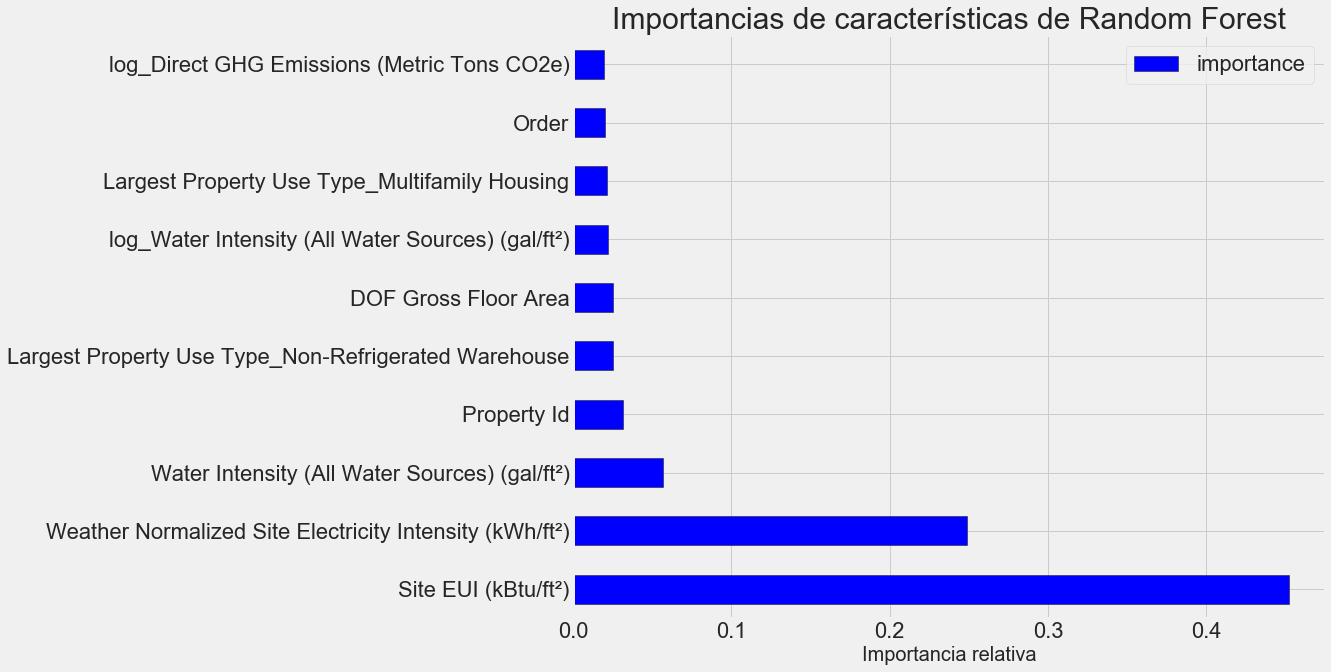

In [8]:
figsize(12, 10)
plt.style.use('fivethirtyeight')

# Dibujamos las 10 características más importantes en un gráfico de barras horizontales
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Importancia relativa', size = 20); plt.ylabel('')
plt.title('Importancias de características de Random Forest', size = 30);

## Uso de la importancia de características para la selección de características

Dado que no todas las características son importantes para encontrar la puntuación, ¿qué pasaría si utilizáramos un modelo más simple, como una regresión lineal, con el subconjunto de las características más importantes del bosque aleatorio? La regresión lineal superó la línea base, pero no tuvo un buen desempeño en comparación con los modelos complejos del modelo. Intentemos usar solo las 10 características más importantes en la regresión lineal para ver si se mejora el rendimiento. También podemos limitar estas características y volver a evaluar el bosque aleatorio.

In [9]:
# Extraemos los nombres de las características más importantes
most_important_features = feature_results['feature'][:10]

# Buscamos el índice que corresponde a cada característica
indices = [list(train_features.columns).index(x) for x in most_important_features]

# Mantenemos solo las características más importantes
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (6622, 10)
Most important testing  features shape:  (2839, 10)


In [10]:
lr = LinearRegression()

# Entrenamos con el conjunto completo de características
lr.fit(X, y)
lr_full_pred = lr.predict(X_test)

# Entrenamos con el conjunto reducido de características
lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

# Mostramos resultados
print('Linear Regression Full Results:    MAE = %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))

Linear Regression Full Results:    MAE = 13.4651.
Linear Regression Reduced Results: MAE = 14.5095.


Bueno, ¡reducir las características no mejoró los resultados de regresión lineal! Resulta que la información adicional en las características con poca importancia realmente mejora el rendimiento.

Veamos cómo usar el conjunto reducido de características en gradient boosted regressor. ¿Cómo se ve afectado el rendimiento?

In [11]:
# Creamos el modelo con los mismos hiperparámetros
model_reduced = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

# Entrenamos y probamos en el conjunto reducido de características
model_reduced.fit(X_reduced, y)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

Gradient Boosted Reduced Results: MAE = 9.3735


Los resultados del modelo son ligeramente peores con el conjunto reducido de características, así que mantendremos todas las características para el modelo final. El deseo de reducir la cantidad de características se debe a que siempre estamos buscando construir el modelo más parco ([parsimonious model](https://www.statisticshowto.datasciencecentral.com/parsimonious-model/)): es decir, el modelo más simple con el rendimiento adecuado. Un modelo que use menos funciones será más rápido de entrenar y, en general, más fácil de interpretar. En este caso, mantener todas las características no es una preocupación importante porque el tiempo de entrenamiento no es significativo y aún podemos hacer interpretaciones con muchas características.

## Locally Interpretable Model-agnostic Explanations

Veremos cómo usar [LIME para explicar las predicciones individuales](https://github.com/marcotcr/lime) realizadas por el modelo. LIME es un esfuerzo relativamente nuevo destinado a mostrar cómo piensa un modelo de aprendizaje automático al aproximar la región alrededor de una predicción con un modelo lineal.

Trataremos de explicar las predicciones en un ejemplo en el que el modelo devuelve algo muy equivocado y en un ejemplo en el que devuelve lo correcto. Nos limitaremos a utilizar el conjunto reducido de 10 funciones para facilitar la interpretación. El modelo entrenado en las 10 características más importantes es un poco menos preciso, ¡pero generalmente tenemos que cambiar la precisión por la interpretabilidad!

In [12]:
# Calculamos los residuos
residuals = abs(model_reduced_pred - y_test)
    
# Exactamente la peor y la mejor predicción
wrong = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

In [13]:
# Creamos un objeto lime
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_reduced, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(most_important_features))

Predicción: 16.3665
Valor Real: 96.0000


c:\program files\python37\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.55969e-27): result may not be accurate.
  overwrite_a=True).T


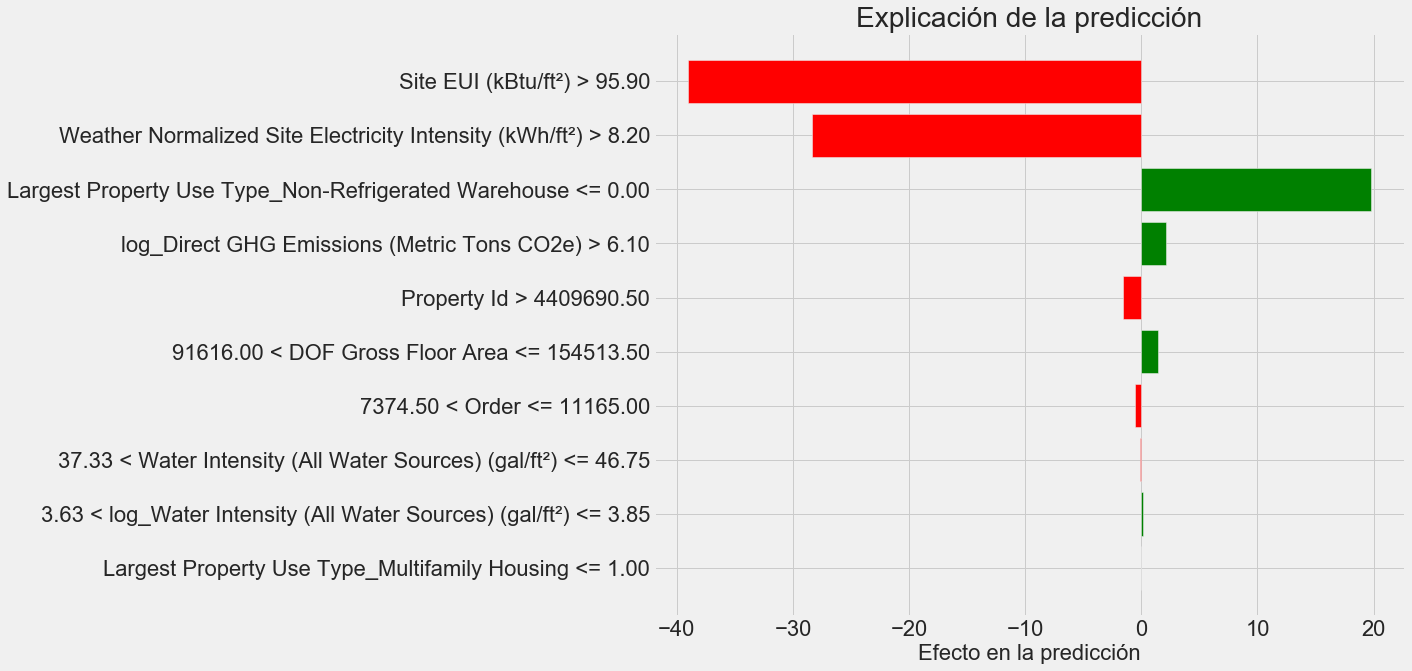

In [14]:
# Muestra el valor predicho y el real para la errónea
print('Predicción: %0.4f' % model_reduced.predict(wrong.reshape(1, -1)))
print('Valor Real: %0.4f' % y_test[np.argmax(residuals)])

# Explicación para la predicción errónea
wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = model_reduced.predict)

# Dibuja la explicación de la predicción
wrong_exp.as_pyplot_figure();
plt.title('Explicación de la predicción', size = 28);
plt.xlabel('Efecto en la predicción', size = 22);

In [15]:
wrong_exp.show_in_notebook(show_predicted_value=False)

En este ejemplo, nuestro modelo gradient boosted predijo una puntuación de 16.37 y el valor real fue de 96.

El gráfico de LIME nos muestra la contribución a la predicción final de cada una de las características del ejemplo. Podemos ver que `Site EUI` disminuyó de manera singular la predicción porque estaba por encima de 95.50. `Weather Normalized Site Electricity Intensity` la disminuyó igualmente porque estaba por encima de 8.20. `Largest Property Use Type_Non-Refrigerated Warehouse`, por otro lado, aumentó la predicción porque era inferior a 0.00.

Podemos interpretar esto diciendo que nuestro modelo pensó que la puntuación Energy Star sería mucho más baja de lo que realmente era porque el `Site EUI` era alto. Sin embargo, en este caso, la puntuación fue de 96 a pesar del alto valor de la EUI. Si bien este error significativo (¡más de 79 puntos!) inicialmente pudo haber sido confuso, ahora podemos ver que en realidad, el modelo estaba razonando el problema y ¡acaba de llegar al valor incorrecto! Un humano que pasa por el mismo proceso probablemente habría llegado a la misma conclusión (si hubiera tenido la paciencia de revisar todos los datos).

Ahora podemos pasar por el mismo proceso con una predicción que el modelo considera como correcta.

Predicción: 100.0000
Valor real: 100.0000


c:\program files\python37\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.82776e-27): result may not be accurate.
  overwrite_a=True).T


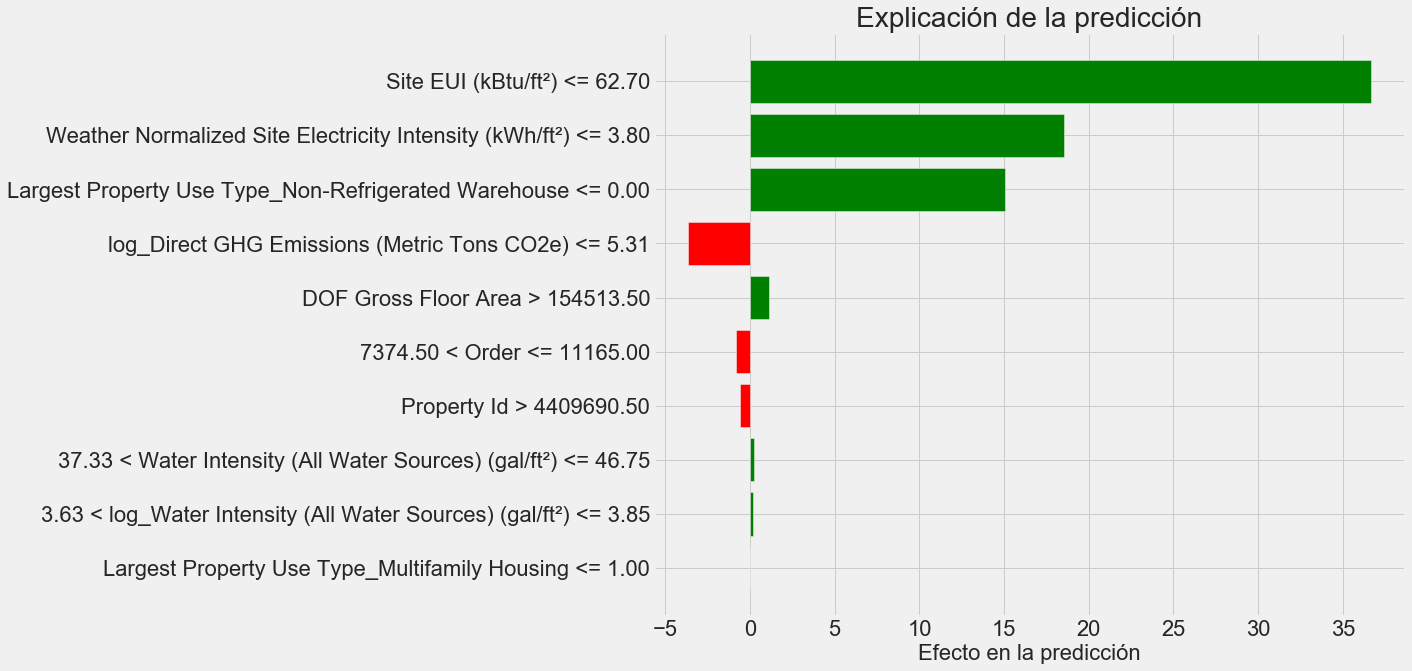

In [16]:
# Muestra el valor predicho y el real para la correcta
print('Predicción: %0.4f' % model_reduced.predict(right.reshape(1, -1)))
print('Valor real: %0.4f' % y_test[np.argmin(residuals)])

# Explicación para la predicción correcta
right_exp = explainer.explain_instance(right, model_reduced.predict, num_features=10)
right_exp.as_pyplot_figure();

plt.title('Explicación de la predicción', size = 28);
plt.xlabel('Efecto en la predicción', size = 22);

In [17]:
right_exp.show_in_notebook(show_predicted_value=False)

El valor correcto para este caso fue 100, ¡nuestro modelo gradient boosted se puso en marcha!

La gráfica de LIME nuevamente muestra la contribución a la predicción de cada una de las variables de características para el ejemplo. Por ejemplo, debido a que `Site EUI` fue menor a 62.70, esto contribuyó significativamente a una estimación más alta de la puntuación. Del mismo modo, `Weather Normalized Site Electricity Intensity (kWh/ft²)` también contribuyó positivamente a la predicción final.

La observación de diagramas de desglose como estos nos permite tener una idea de cómo el modelo hace una predicción. Probablemente esto sea más valioso para los casos en los que el modelo está desviado en una gran cantidad, ya que podemos inspeccionar los errores y quizás diseñar mejores características o ajustar los parámetros del modelo para mejorar las predicciones para la próxima vez. Los ejemplos en los que el modelo está más desviado también podrían ser casos interesantes para verlos manualmente. El modelo subestimó drásticamente la puntuación de Energy Star para el primer edificio debido al elevado `Site EUI`. Por lo tanto, podríamos preguntarnos por qué el edificio tiene una puntuación Energy Star tan alto a pesar de que tiene un alto IUE. ¡Un proceso como este, en el que tratamos de trabajar con el algoritmo de machine learning para comprender mejor un problema, parece mucho mejor que simplemente dejar que el modelo haga predicciones y confiar completamente en ellas! Aunque LIME no es perfecto, representa un paso en la dirección correcta hacia la explicación de los modelos de machine learning.

## Examinando un único árbol de decisión

Una de las partes más interesantes de un conjunto basado en árboles es que podemos ver cualquier estimador individual. Si bien nuestro modelo final está compuesto por 800 árboles de decisión y mirar uno solo no es indicativo de todo el modelo, nos permite ver la idea general de cómo funciona un árbol de decisión. A partir de ahí, es una extensión natural imaginar a cientos de estos árboles [construyendo a partir de los errores de los árboles anteriores](https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d) para hacer una predicción final (¡esto es una simplificación significativa de cómo funciona la [gradient boosting regression](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)!)

Primero extraeremos un árbol del bosque y luego lo guardaremos usando `sklearn.tree.export_graphviz`. Esto guarda el árbol como un archivo `.dot` que se puede convertir a un png usando las instrucciones de línea de comandos en el notebook.

In [18]:
# Extraemos un único árbol
single_tree = model_reduced.estimators_[105][0]

tree.export_graphviz(single_tree, out_file = './images/tree.dot',
                     rounded = True, 
                     feature_names = most_important_features,
                     filled = True)

single_tree

DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=6, min_samples_split=6,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x00000118FD67A798>,
           splitter='best')

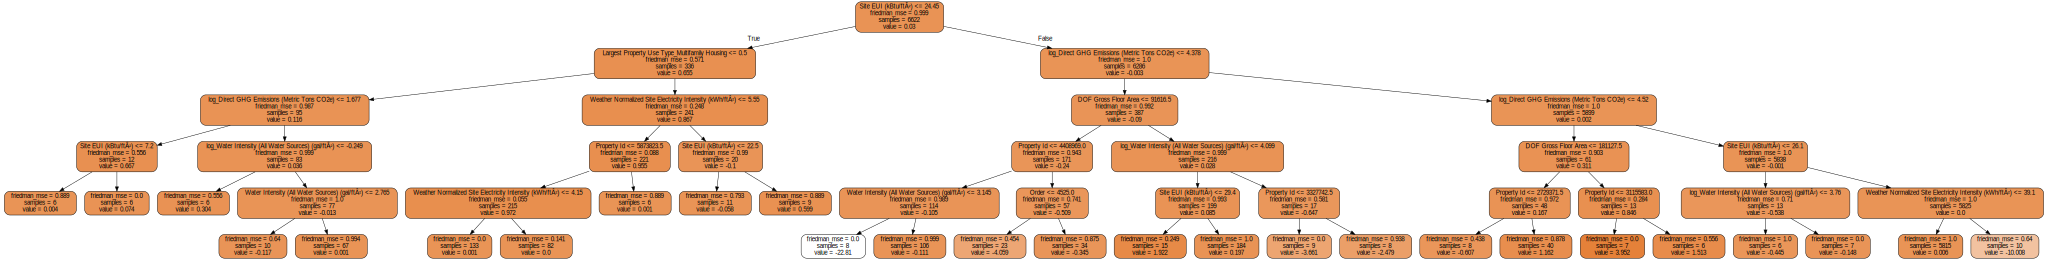

In [19]:
import os
from graphviz import Source
file = open("./images/tree.dot", "r")
text = file.read()
Source(text)

¡Eso es un árbol entero en nuestro regresor de 800! Es un poco difícil de descifrar porque la profundidad máxima del árbol es 5. Para mejorar la legibilidad, podemos limitar la profundidad máxima en la llamada para exportar nuestro árbol.

In [20]:
tree.export_graphviz(single_tree, out_file = './images/tree_small.dot',
                     rounded = True, feature_names = most_important_features,
                     filled = True, max_depth = 3)

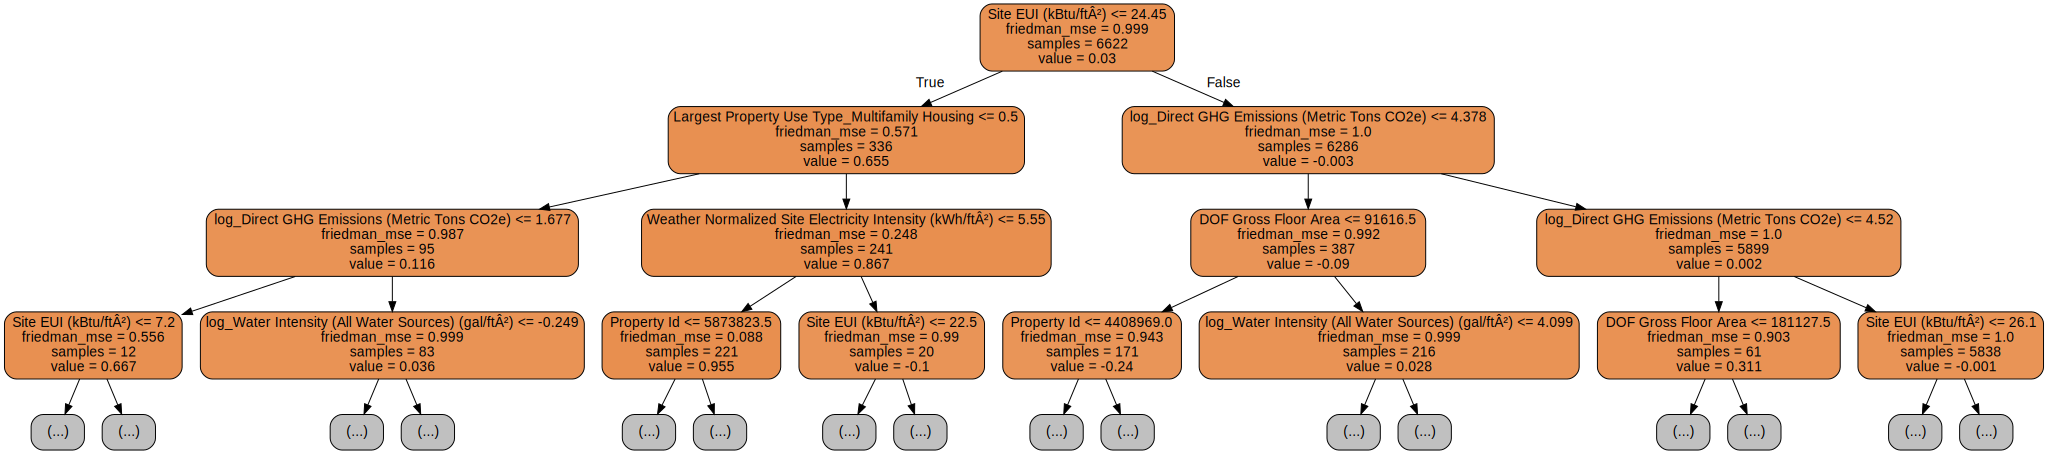

In [21]:
file = open("./images/tree_small.dot", "r")
text = file.read()
Source(text)

¡Ahora podemos echar un vistazo al árbol e intentar interpretar sus decisiones! La mejor manera de pensar en un árbol de decisiones es como una serie de preguntas de sí / no, como un diagrama de flujo. Comenzamos en la parte superior, llamada la raíz y avanzamos por el árbol en la dirección determinada por la respuesta a cada ecuación.

Por ejemplo, aquí la primera pregunta que hacemos es: ¿es `Site EUI` menor o igual a 24.45? Si la respuesta es sí entonces nos movemos hacia la izquierda y hacemos la pregunta: ¿`Largest Property Use Type_Multifamily Housing` es menor o igual a 0.5? Si la respuesta a la primera pregunta fue no nos movemos a la derecha y la pregunta es: ¿`log_Direct GHG Emissions (Metric Tons CO2e)` es menor o igual a 4.378?

Continuamos este proceso iterativo hasta que llegamos a la parte inferior del árbol y terminamos en un nodo de hoja. Aquí el valor que predecimos corresponde al valor que se muestra en el nodo (los valores de este árbol parecen ser las predicciones reales divididas por 100).

Cada nodo tiene cuatro datos diferentes:

+ **La pregunta**: en función de esta respuesta, nos movemos hacia la derecha o hacia la izquierda hasta el siguiente nodo, una capa hacia abajo en el árbol
+ **friedman_mse**: una medida del error para todos los ejemplos en un nodo dado
+ **Las muestras**: número de ejemplos en un nodo.
+ **El valor**: la predicción del objetivo para todos los ejemplos en un nodo

Podemos ver que a medida que aumentamos la profundidad del árbol, podremos ajustar mejor los datos. Con un árbol pequeño, habrá muchos ejemplos en cada nodo hoja y como el modelo estima el mismo valor para cada ejemplo en un nodo probablemente habrá un error mayor (a menos que todos los ejemplos tengan el mismo valor objetivo). La construcción de un árbol demasiado grande, sin embargo, puede llevar a overfitting. Podemos controlar una serie de hiperparámetros que determinan la profundidad del árbol y el número de ejemplos en cada hoja. Vimos cómo seleccionar algunos de estos hiperparámetros en la segunda parte cuando realizamos la optimización utilizando la validación cruzada.

Aunque claramente no podemos examinar todos los árboles en nuestro modelo, el observar uno solo nos da una idea de cómo nuestro modelo hace predicciones. De hecho, este método basado en un diagrama de flujo se parece mucho a cómo un ser humano toma decisiones, respondiendo una pregunta sobre un valor único a la vez. Los árboles de decisión basados en conjuntos simplemente toman la idea de un solo árbol de decisión y combinan las predicciones de muchos individuos para crear un modelo con menor varianza que un solo estimador. ¡Los conjuntos de árboles tienden a ser muy precisos y también son intuitivos de explicar!

# Sacar conclusiones y documentar hallazgos

La parte final del flujo de machine learning podría ser la más importante: debemos comprimir todo lo que hemos aprendido en un breve resumen que resalte solo los hallazgos más importantes. Personalmente, tengo dificultades para evitar explicar todos los detalles técnicos porque disfruto de todo el trabajo. Sin embargo, la persona a la que te estás presentando probablemente no tiene mucho tiempo para escuchar todos los detalles y solo quiere escuchar los puntos clave. Aprender a extraer los elementos más importantes un proyecto de data science o machine learning es una habilidad crucial, porque si los resultados no son entendidos por otros, ¡entonces nunca se utilizarán!

Os aliento a que presentéis vuestras propias conclusiones, pero aquí están mis 2 principales diseñadas para ser comunicadas en 30 segundos:

1. Utilizando los datos de energía del edificio dados, un modelo de machine learning puede predecir la puntuación Energy Star de un edificio dentro de un margen de 10 puntos.
2. Las variables más importantes para determinar la puntuación Energy Star son la intensidad de uso de energía (Energy Use Intensity), la intensidad de uso de electricidad (Electricity Use Intensity) y la intensidad de uso de agua (Water Use Intensity).

Si alguien solicita los detalles, entonces podemos explicar fácilmente todos los pasos de la implementación y presentar nuestro (con suerte) trabajo bien documentado. Otro aspecto crucial de un proyecto de machine learning es que has comentado todo su código y lo has hecho fácil de seguir. Deseas que otra persona (o tú mismo en unos pocos meses) pueda ver tu trabajo y entender completamente las decisiones que tomaste. Lo ideal es escribir código con la intención de que se vuelva a utilizar. Incluso cuando hacemos proyectos por nosotros mismos, es bueno practicar la documentación adecuada, te facilitará mucho la vida cuando desees revisar un proyecto.

### Presentación de tu trabajo

Uno de los mejores aspectos de los Jupyter Notebooks es que se pueden descargar directamente como un pdf o html y luego compartir con otros. Mi informe final se [puede ver aquí](https://github.com/WillKoehrsen/machine-learning-project-walkthrough/blob/master/Building%20Data%20Report.pdf) (se diferencia un poco de este proyecto porque lo hice en un marco de tiempo comprimido e hice algunas elecciones de modelado diferentes). Después de terminar el notebook, lo descargué como .tex, hice algunos pequeños cambios en [texStudio](https://www.texstudio.org/) y luego lo compilé en un pdf. ¡La versión final se ve un poco mejor que el PDF predeterminado de Jupyter Notebook y vale la pena aprender un poco de [latex](https://www.latex-project.org/) para crear informes más profesionales!

Con eso en mente, creo que es hora de que terminemos este proyecto. Me divertí mucho escribiendo estos notebooks y haciendo el análisis, y espero que hayas disfrutado leyendo esto y ahora te sientas más seguro al implementar tu propio proyecto de machine learning. Si lo deseas, puedes comenzar modificando este proyecto e intentando superar a mis modelos. Recuerda, no sientas que tienes que hacerlo solo: hay muchos recursos asombrosos de machine learning por ahí, procedentes de personas totalmente autodidactas gracias a la gran comunidad de data science, la mejor manera de aprender es ¡Participa y comienza a poner tu trabajo ahí fuera!

Recursos de data science y machine learning:

+ [Hands-On Machine Learning with Scikit-Learn and Tensorflow](http://shop.oreilly.com/product/0636920052289.do)
 + Los [Jupyter Notebooks de este libro](https://github.com/ageron/handson-ml) están disponibles online gratuitamente
+ [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)
+ [Kaggle: The Home of Data Science and Machine Learning](https://www.kaggle.com/)
+ [Datacamp: Good Beginner Tutorials for Practicing Coding with a Focus on Data Science](https://www.datacamp.com/)
+ [Dataquest: Hands on Lessons for Data Science Programming](https://www.dataquest.io/)

Este artículo:
+ [ Complete Machine Learning Project Walk-Through in Python](https://codequs.com/p/BkaLEq8r4/a-complete-machine-learning-project-walk-through-in-python)